In [55]:
import pandas as pd
full_merged=pd.read_csv('/Users/ahmadkhalilghamai/Desktop/IH-DA-Project02/my project csv files/full_merged.csv')
full_merged.head()

/var/folders/l4/g8j3y_vx0pq5tl_95dwxp9hr0000gp/T/ipykernel_16460/1149574145.py:2: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  full_merged=pd.read_csv('/Users/ahmadkhalilghamai/Desktop/IH-DA-Project02/my project csv files/full_merged.csv')


,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,is_client,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,variation
0,0,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,True,6.0,73.0,60.5,NaN,2.0,45105.30,6.0,9.0,Test
1,1,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,True,7.0,94.0,58.0,NaN,2.0,110860.30,6.0,9.0,Test
2,2,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,True,5.0,64.0,32.0,NaN,2.0,52467.79,6.0,9.0,Test
3,3,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,True,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test
4,4,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15,True,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Test


In [57]:

full_merged['date_time'] = pd.to_datetime(full_merged['date_time'], errors='coerce')

In [59]:
#calculating the error rates per steps without considering the variation(Test/Control)

import pandas as pd

def calculate_step_error_rates(full_merged):
    """
    Calculate error rates for each process step in a user journey
    
    Error Rate = (Number of repeated attempts at a step) / (Total attempts at that step)
    
    Parameters:
        df: DataFrame containing process data with columns:
            - visitor_id: unique user identifier
            - process_step: the step in the funnel (start, step_1, etc.)
            - date_time: timestamp of the step completion
            
    Returns:
        DataFrame with error rates for each process step, sorted by error rate
    """
    # Sort data by user and time to ensure proper sequence
    full_merged= full_merged.sort_values(['visitor_id', 'date_time'])
    
    # Mark repeated steps (same user repeating same step)
    full_merged['is_repeated'] = full_merged.duplicated(['visitor_id', 'process_step'], keep=False)
    
    # Calculate total attempts per step
    total_attempts = full_merged.groupby('process_step').size().reset_index(name='total_attempts')
    
    # Calculate repeated attempts per step (errors)
    error_attempts = full_merged[full_merged['is_repeated']].groupby('process_step').size().reset_index(name='error_attempts')
    
    # Merge and calculate error rate percentage
    error_rates = pd.merge(total_attempts, error_attempts, on='process_step', how='left')
    error_rates['error_attempts'] = error_rates['error_attempts'].fillna(0)
    error_rates['error_rate'] = (error_rates['error_attempts'] / error_rates['total_attempts']) * 100
    
    return error_rates.sort_values('error_rate', ascending=False)
    

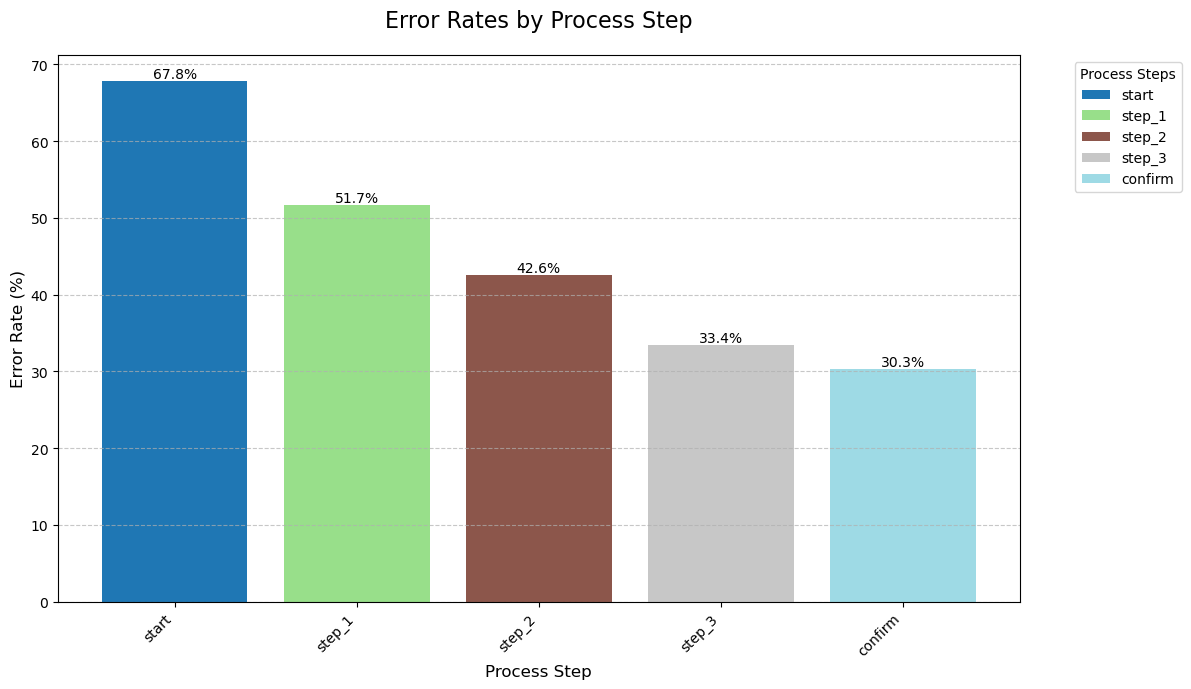

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Calculate error rates
error_rates = calculate_step_error_rates(full_merged)

# Create a color palette - one distinct color per step
step_colors = plt.cm.tab20(np.linspace(0, 1, len(error_rates)))

# Visualization
plt.figure(figsize=(12, 7))
bars = plt.bar(error_rates['process_step'], error_rates['error_rate'], 
               color=step_colors)
plt.title('Error Rates by Process Step', fontsize=16, pad=20)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10)


plt.legend(bars, error_rates['process_step'], 
title='Process Steps',
bbox_to_anchor=(1.05, 1), 
loc='upper left')

plt.tight_layout()
plt.show()

In [63]:
error_rates

,process_step,total_attempts,error_attempts,error_rate
1,start,141416,95942,67.843808
2,step_1,95507,49401,51.725004
3,step_2,79266,33765,42.597078
4,step_3,67586,22602,33.441837
0,confirm,60121,18227,30.317194


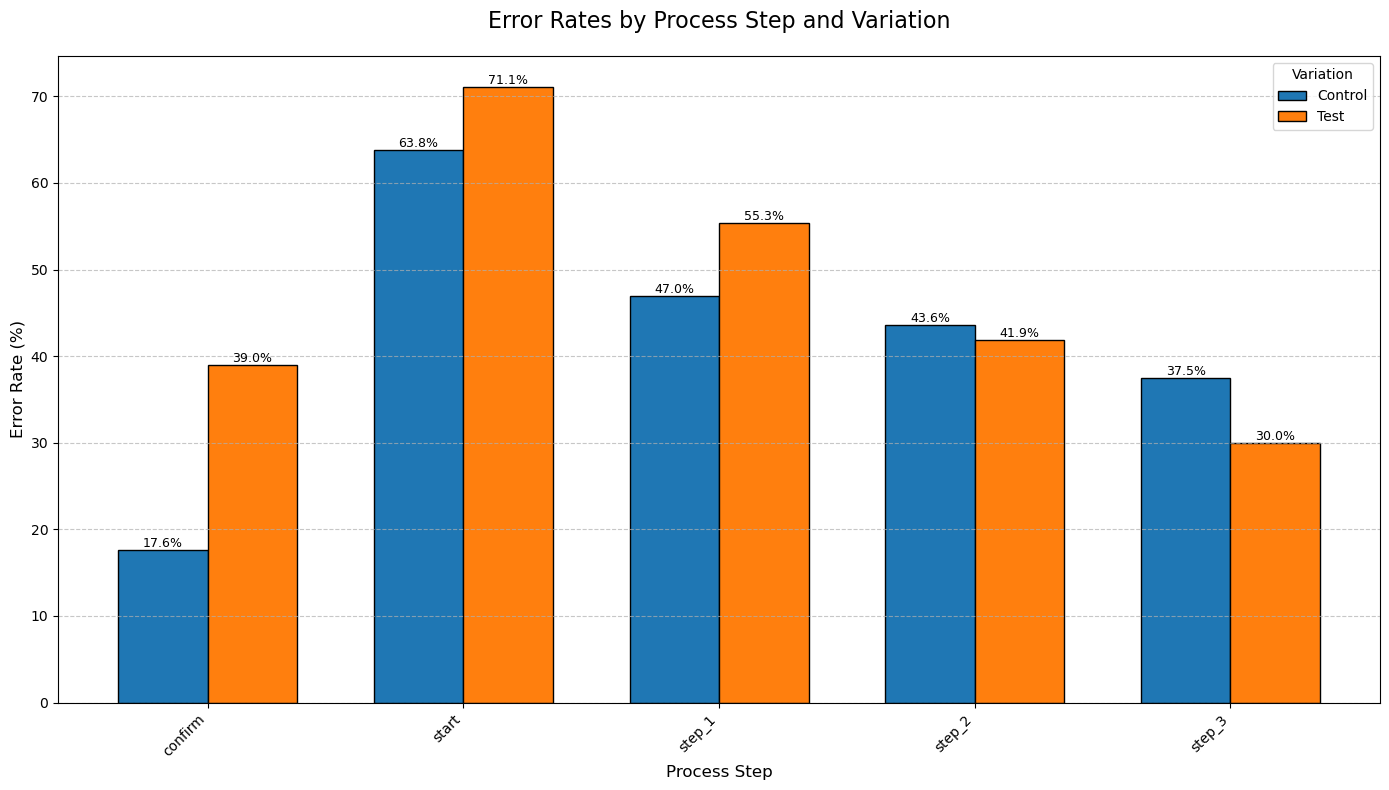

In [65]:

# Modified error rate calculation function to include variation
def calculate_error_rates_by_variation(full_merged):
    full_merged= full_merged.sort_values(['visitor_id', 'date_time'])
    full_merged['is_repeated'] = full_merged.duplicated(['visitor_id', 'process_step'], keep=False)
    
    # Group by both process_step and variation
    total_attempts = full_merged.groupby(['process_step', 'variation']).size().reset_index(name='total_attempts')
    error_attempts = full_merged[full_merged['is_repeated']].groupby(['process_step', 'variation']).size().reset_index(name='error_attempts')
    
    # Merge and calculate error rate
    error_rates = pd.merge(total_attempts, error_attempts, on=['process_step', 'variation'], how='left')
    error_rates['error_attempts'] = error_rates['error_attempts'].fillna(0)
    error_rates['error_rate'] = (error_rates['error_attempts'] / error_rates['total_attempts']) * 100
    
    return error_rates

# Calculate error rates by variation
error_rates_variation = calculate_error_rates_by_variation(full_merged)

# Pivot for plotting
pivot_df = error_rates_variation.pivot(index='process_step', columns='variation', values='error_rate')

# Visualization
plt.figure(figsize=(14, 8))
bar_width = 0.35
x = np.arange(len(pivot_df))

# Plot bars for Control and Test
bars_control = plt.bar(x - bar_width/2, pivot_df['Control'], width=bar_width, 
                      label='Control', color='#1f77b4', edgecolor='black')
bars_test = plt.bar(x + bar_width/2, pivot_df['Test'], width=bar_width, 
                   label='Test', color='#ff7f0e', edgecolor='black')

plt.title('Error Rates by Process Step and Variation', fontsize=16, pad=20)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.xticks(x, pivot_df.index, rotation=45, ha='right')
plt.legend(title='Variation')

# Add value labels
for bars in [bars_control, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

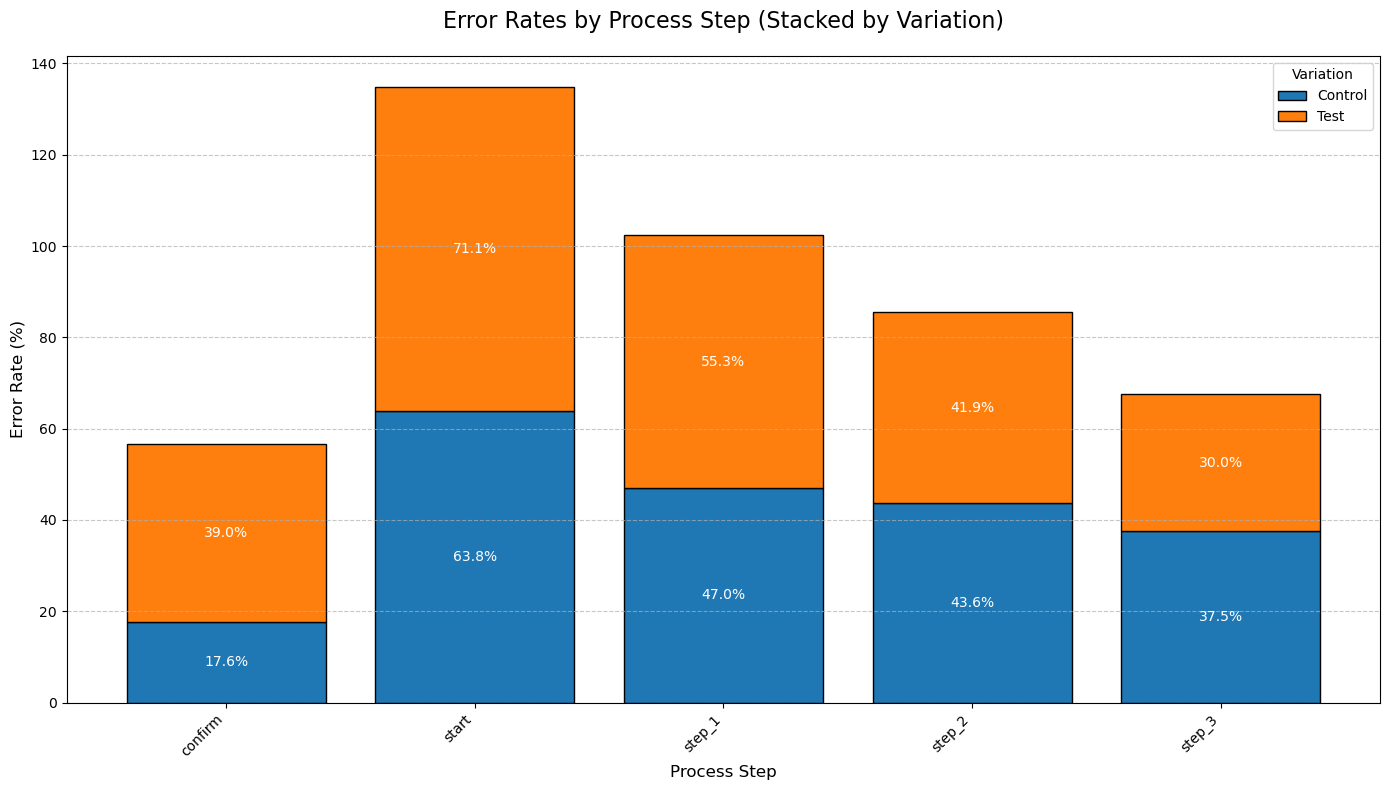

In [67]:
plt.figure(figsize=(14, 8))

# Create stacked bar chart
bars_control = plt.bar(pivot_df.index, pivot_df['Control'], 
                      label='Control', color='#1f77b4', edgecolor='black')
bars_test = plt.bar(pivot_df.index, pivot_df['Test'], 
                   bottom=pivot_df['Control'],
                   label='Test', color='#ff7f0e', edgecolor='black')

plt.title('Error Rates by Process Step (Stacked by Variation)', fontsize=16, pad=20)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Variation')

# Add value labels
for i, (ctrl, test) in enumerate(zip(pivot_df['Control'], pivot_df['Test'])):
    plt.text(i, ctrl/2, f'{ctrl:.1f}%', ha='center', va='center', color='white')
    plt.text(i, ctrl + test/2, f'{test:.1f}%', ha='center', va='center', color='white')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
error_rates_variation

,process_step,variation,total_attempts,error_attempts,error_rate
0,confirm,Control,17336,3045,17.564605
1,confirm,Test,25600,9978,38.976562
2,start,Control,45380,28953,63.801234
3,start,Test,55773,39673,71.132985
4,step_1,Control,29544,13885,46.997698
5,step_1,Test,38666,21393,55.327678
6,step_2,Control,25773,11245,43.630932
7,step_2,Test,30899,12948,41.904269
8,step_3,Control,22503,8433,37.475003
9,step_3,Test,25760,7730,30.007764


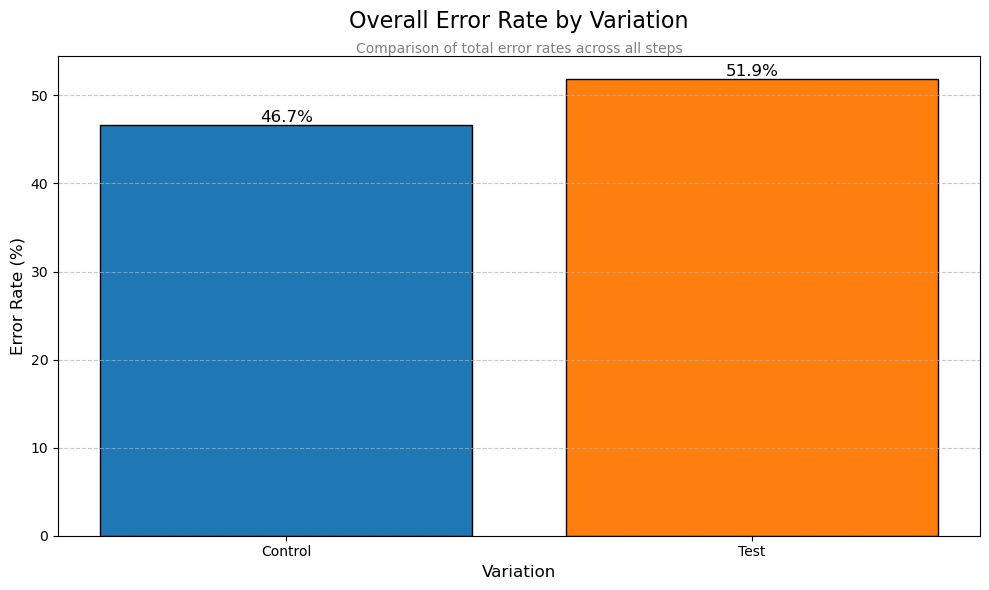

In [71]:


# Calculate overall error rates by variation
def calculate_overall_error_rates(full_merged):
    full_merged = full_merged.sort_values(['visitor_id', 'date_time'])
    full_merged['is_repeated'] = full_merged.duplicated(['visitor_id', 'process_step'], keep=False)
    
    # Group by variation
    total_attempts = full_merged.groupby('variation').size().reset_index(name='total_attempts')
    error_attempts = full_merged[full_merged['is_repeated']].groupby('variation').size().reset_index(name='error_attempts')
    
    # Merge and calculate error rate
    error_rates = pd.merge(total_attempts, error_attempts, on='variation', how='left')
    error_rates['error_attempts'] = error_rates['error_attempts'].fillna(0)
    error_rates['error_rate'] = (error_rates['error_attempts'] / error_rates['total_attempts']) * 100
    
    return error_rates

# Calculate overall error rates
overall_error_rates = calculate_overall_error_rates(full_merged)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(overall_error_rates['variation'], overall_error_rates['error_rate'], 
               color=['#1f77b4', '#ff7f0e'], edgecolor='black')

plt.title('Overall Error Rate by Variation', fontsize=16, pad=20)
plt.xlabel('Variation', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

# Add statistical significance marker if applicable
max_height = max(overall_error_rates['error_rate'])
plt.text(0.5, max_height * 1.05, 
         'Comparison of total error rates across all steps', 
         ha='center', va='bottom', fontsize=10, color='gray')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [77]:
overall_error_rates

,variation,total_attempts,error_attempts,error_rate
0,Control,140536,65561,46.650680
1,Test,176698,91722,51.908907


In [75]:
# relative improvement
control_rate = overall_error_rates.loc[overall_error_rates['variation'] == 'Control', 'error_rate'].values[0]
test_rate = overall_error_rates.loc[overall_error_rates['variation'] == 'Test', 'error_rate'].values[0]
improvement = (control_rate - test_rate) / control_rate * 100

print(f"Test variation showed {'improvement' if improvement > 0 else 'worsening'} of {abs(improvement):.1f}% "
      f"compared to Control")

Test variation showed worsening of 11.3% compared to Control


/var/folders/l4/g8j3y_vx0pq5tl_95dwxp9hr0000gp/T/ipykernel_16460/3651200147.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backward_df['is_repeated'] = backward_df.duplicated(['visitor_id', 'process_step'], keep=False)


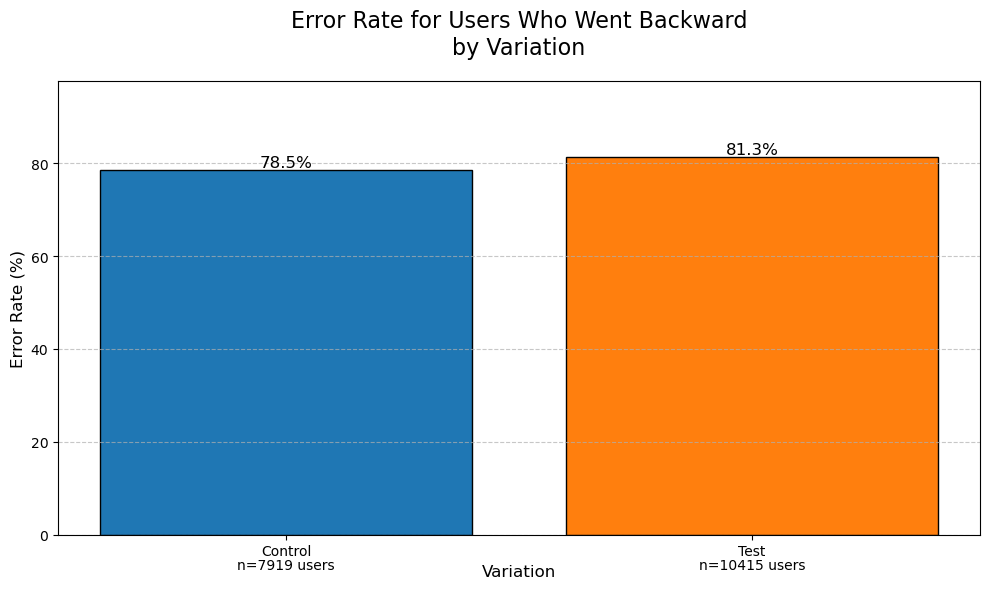

In [87]:

# Convert date_time to datetime and sort
full_merged['date_time'] = pd.to_datetime(  full_merged['date_time'])
full_merged =full_merged.sort_values(['visitor_id', 'date_time'])

# Create mapping of step order
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
full_merged['step_num'] =   full_merged['process_step'].map(step_order)

# Identify backward movements
full_merged['next_step'] =   full_merged.groupby('visitor_id')['step_num'].shift(-1)
full_merged['step_diff'] =   full_merged['next_step'] -   full_merged['step_num']
full_merged['went_backward'] =   full_merged['step_diff'] < 0

# Calculate error rates by variation
def calculate_backward_error_rates(df):
    # Filter to only users who went backward at least once
    backward_users =   full_merged[  full_merged['went_backward']]['visitor_id'].unique()
    backward_df =   full_merged[  full_merged['visitor_id'].isin(backward_users)]
    
    # Calculate error rates (repeated steps) for these users
    backward_df['is_repeated'] = backward_df.duplicated(['visitor_id', 'process_step'], keep=False)
    
    # Group by variation
    total_attempts = backward_df.groupby('variation').size().reset_index(name='total_attempts')
    error_attempts = backward_df[backward_df['is_repeated']].groupby('variation').size().reset_index(name='error_attempts')
    
    # Merge and calculate error rate
    error_rates = pd.merge(total_attempts, error_attempts, on='variation', how='left')
    error_rates['error_attempts'] = error_rates['error_attempts'].fillna(0)
    error_rates['error_rate'] = (error_rates['error_attempts'] / error_rates['total_attempts']) * 100
    
    return error_rates

backward_error_rates = calculate_backward_error_rates(full_merged)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(backward_error_rates['variation'], backward_error_rates['error_rate'],
               color=['#1f77b4', '#ff7f0e'], edgecolor='black')

plt.title('Error Rate for Users Who Went Backward\nby Variation', fontsize=16, pad=20)
plt.xlabel('Variation', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

# Add sample size annotations
sample_sizes =   full_merged[  full_merged['visitor_id'].isin(  full_merged[  full_merged['went_backward']]['visitor_id'].unique())]\
                .groupby('variation')['visitor_id'].nunique()
for i, var in enumerate(backward_error_rates['variation']):
    plt.text(i, -5, f'n={sample_sizes[var]} users',
             ha='center', va='top', fontsize=10)

plt.ylim(0, max(backward_error_rates['error_rate']) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [89]:
# Percentage of users who went backward by variation
backward_users = full_merged[full_merged['went_backward']].groupby('variation')['visitor_id'].nunique()
total_users = full_merged.groupby('variation')['visitor_id'].nunique()
backward_pct = (backward_users / total_users * 100).reset_index(name='pct_backward')

print("\nPercentage of users who went backward:")
print(backward_pct)

# Average number of backward movements per user
backward_counts = full_merged[full_merged['went_backward']].groupby(['variation', 'visitor_id']).size()\
                    .groupby('variation').mean().reset_index(name='avg_backward_moves')
print("\nAverage backward movements per user:")
print(backward_counts)


Percentage of users who went backward:
  variation  pct_backward
0   Control     29.638087
1      Test     34.473077

Average backward movements per user:
  variation  avg_backward_moves
0   Control            1.580894
1      Test            1.783595
